In [6]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy.integrate import quad, solve_ivp

from lib.lib_fluxes import *

# U239 and Np239 fluxes

## Importing the BESTIOLE data

In [2]:
breeding_isotopes_txtfile_format = ['u239', 'np239']

spectrum_source = 'bestiole'

bestiole_breeding_spectra_data = []
bestiole_breeding_spectra = []

for fi in breeding_isotopes_txtfile_format:
    spec = get_spectrum(f"fluxData/{spectrum_source}_{fi}.txt")
    bestiole_breeding_spectra_data.append(spec)

    bestiole_breeding_spectra.append(CubicSpline(*spec, extrapolate=False))


Text(0, 0.5, 'Rate (/fission/MeV)')

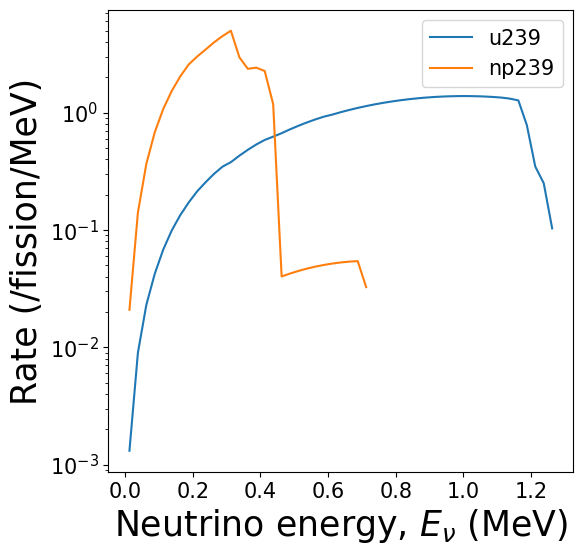

In [3]:
fig, ax = plt.subplots(figsize=(6,6))

for fi, spec_data in zip(breeding_isotopes_txtfile_format, bestiole_breeding_spectra_data):
    ax.plot(spec_data[0]/MeV, spec_data[1]*MeV, label=fi)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.tick_params(labelsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/fission/MeV)", fontsize=25)

I also want to test the normalisation of these fluxes by integrating them. If the are normalised (which they are), they should integrate to 1, as 1 neutrino is released for each beta decay

In [32]:
for spec, data in zip(bestiole_breeding_spectra, bestiole_breeding_spectra_data):
    Enu_min = data[0][0]
    Enu_max = data[0][-1]
    print(quad(spec, Enu_min, Enu_max)[0])

0.9994384594996103
0.9995494020031703


## Comparing to the CONFLXUX data

These results are taken from spectra generated using CONFLUX, a new program made by a team in the US associated with MINER that Jay has contact with (through Bryce Littlejohn)

They generated spectra for a pressurised water reactor midway through its cycle, with and without U239/Np239. So, taking the difference of the two spectra should result in the spectra for just U239 and Np239

In [4]:
CONFLUX_hfir_per_sec_df = pd.read_csv('./spectra/hfir_per_sec.csv')
CONFLUX_breeding_spectra_df = pd.read_csv('./spectra/breeding_U239_Np239.dat', sep='\t', header=None)

CONFLUX_nu_energies_MeV = np.array(CONFLUX_hfir_per_sec_df.e) # The units are MeV
CONFLUX_hfir_spectrum = np.array(CONFLUX_hfir_per_sec_df.spectrum) # The units are ?/second/MeV for a ?GW reactor

CONFLUX_nu_energies = np.array(CONFLUX_breeding_spectra_df[0]) # The variable name does not specify units b/c it is in GeV
CONFLUX_breeding_spectrum = np.array(CONFLUX_breeding_spectra_df[1])



### Looking at the CONFLUX HFIR spectrum

I want to test what HFIR per sec actually is a spectrum of: is it an 85 MW HFIR reactor (with pure U235 as fuel?) or a GW pressurised water reactor halfway through its cycle? Let's compare

Text(0, 0.5, 'Rate (/second/MeV)')

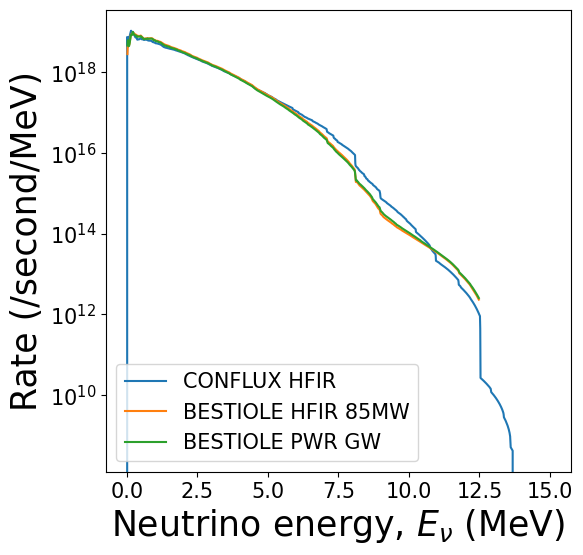

In [74]:
fig, ax = plt.subplots(figsize=(6,6))

BESTIOLE_85MW_HFIR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [1,0,0,0])(CONFLUX_nu_energies)
BESTIOLE_GW_PWR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [53,8,32,7])(CONFLUX_nu_energies)

ax.plot(CONFLUX_nu_energies_MeV, CONFLUX_hfir_spectrum, label='CONFLUX HFIR')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_85MW_HFIR_spec*SECOND*MeV, label='BESTIOLE HFIR 85MW')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_GW_PWR_spec*SECOND*MeV, label='BESTIOLE PWR GW')

ax.set_yscale('log')
ax.tick_params(labelsize=15)
# ax.set_ylim(1e0, 1e30)
# ax.set_xlim(0,2.5)

ax.legend(fontsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/second/MeV)", fontsize=25)

So it's definitely an 85MW reactor - however, it's a bit tricky to disentangle whether it's HFIR (pure U235) or a PWR mix, as they seemingly coincidentally have very similar neutrino spectra. We'll show this by taking ratios of the given fluxes to the CONFLUX flux

Text(0, 0.5, 'Rate/CONFLUX rate')

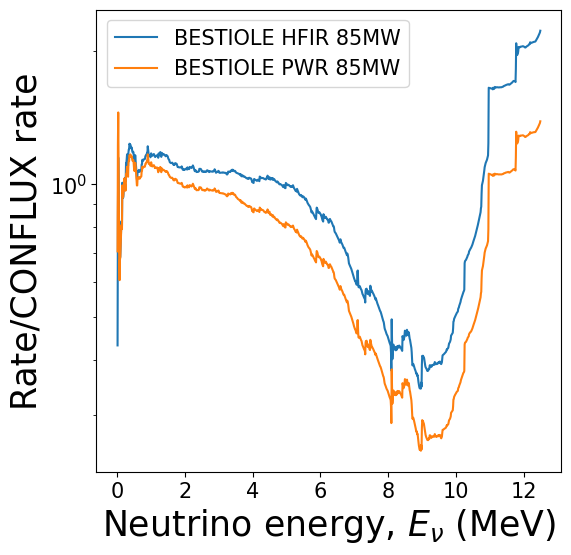

In [73]:
fig, ax = plt.subplots(figsize=(6,6))

BESTIOLE_85MW_HFIR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [1,0,0,0])(CONFLUX_nu_energies)
BESTIOLE_GW_PWR_spec = get_reactor_flux_Pth_fuel_fractions(0.085*GIGAWATT, [53,0,47,0])(CONFLUX_nu_energies)

# ax.plot(CONFLUX_nu_energies_MeV, CONFLUX_hfir_spectrum, label='CONFLUX HFIR')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_85MW_HFIR_spec*SECOND*MeV/CONFLUX_hfir_spectrum, label='BESTIOLE HFIR 85MW')
ax.plot(CONFLUX_nu_energies_MeV, BESTIOLE_GW_PWR_spec*SECOND*MeV/CONFLUX_hfir_spectrum, label='BESTIOLE PWR 85MW')

ax.set_yscale('log')
ax.tick_params(labelsize=15)

ax.legend(fontsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate/CONFLUX rate", fontsize=25)

### Comparing the CONFLUX breeding isotopes and the BESTIOLE breeding isotopes

First, I need to make code to combine the two breeding spectra (U239 and Np239)

- 1st idea:

I was told by Jay (apparently quoting CONFLUX) that the thermal power from the breeding neutrinos was 22% of the original thermal power, i.e. 220 MW.
Assume that U239 and Np239 contribute to this with an equal number of decays. The total energy from the two decays the sum of $Q_\beta$ for the two decays, giving

$Q_\beta^\mathrm{total} = 1.9846$ MeV 

- 2nd idea:

Just adding the two spectra together, since if one happens, then the other one will happen (eventually). To get a rate/second to compare to CONFLUX, the combined spectrum is scaled by asserting that 0.6 n absorptions occur for every fission in the reactor (from 1405.5761), and that the reactor has 1 GW of power (following 1405.5761)

In [26]:
BESTIOLE_breeding_spec_nu_energies = np.linspace(0, 1.5*MeV, 100)

BESTIOLE_breeding_spectrum_22_per_cent_of_1GW = []
BESTIOLE_breeding_spectrum_60_percent_n_aborp_per_fission_1GW = []

# For the 1st idea:
thermal_power = 0.22*GIGAWATT

beta_decay_energy_u239 = 1.2617*MeV
beta_decay_energy_np239 = 0.7229*MeV

total_beta_decay_energy = beta_decay_energy_u239 + beta_decay_energy_np239

total_n_absorp_1 = thermal_power/total_beta_decay_energy

# For the 2nd idea:
thermal_power = GIGAWATT
mean_energy_per_fission = sum(ENERGY_PER_FISSION_I*np.array([0.56, 0.08, 0.3, 0.06])) 
# ^ This is a typical fuel composition, and matches the composition given in 1405.5761
total_fissions = thermal_power/mean_energy_per_fission
total_n_absorp_2 = 0.6*total_fissions

for Enu in BESTIOLE_breeding_spec_nu_energies:
    bestiole_u239 = bestiole_breeding_spectra[0](Enu)
    if np.isnan(bestiole_u239):
        bestiole_u239 = 0
    bestiole_np239 = bestiole_breeding_spectra[1](Enu)
    if np.isnan(bestiole_np239):
        bestiole_np239 = 0


    combined_spectrum_GW = (bestiole_u239 + bestiole_np239)

    BESTIOLE_breeding_spectrum_22_per_cent_of_1GW.append(total_n_absorp_1*combined_spectrum_GW)
    BESTIOLE_breeding_spectrum_60_percent_n_aborp_per_fission_1GW.append(total_n_absorp_2*combined_spectrum_GW)

Text(0, 0.5, 'Rate (/second/MeV)')

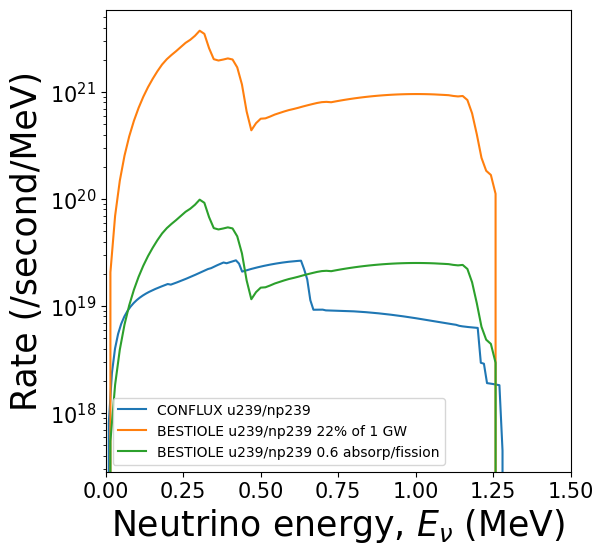

In [28]:
fig, ax = plt.subplots(figsize=(6,6))

# for fi, spec_data in zip(breeding_isotopes_txtfile_format, bestiole_breeding_spectra_data):
#     ax.plot(spec_data[0]/MeV, spec_data[1], label='BESTIOLE ' + fi)

ax.plot(CONFLUX_nu_energies_MeV, CONFLUX_breeding_spectrum*SECOND*MeV, label='CONFLUX u239/np239')

ax.plot(BESTIOLE_breeding_spec_nu_energies/MeV, np.array(BESTIOLE_breeding_spectrum_22_per_cent_of_1GW)*SECOND*MeV, label='BESTIOLE u239/np239 22% of 1 GW')
ax.plot(BESTIOLE_breeding_spec_nu_energies/MeV, np.array(BESTIOLE_breeding_spectrum_60_percent_n_aborp_per_fission_1GW)*SECOND*MeV, label='BESTIOLE u239/np239 0.6 absorp/fission')

ax.legend(fontsize=10)

ax.set_yscale('log')
ax.tick_params(labelsize=15)

ax.set_xlim(0,1.5)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/second/MeV)", fontsize=25)

While the shape is a bit different between the two possibilities, the overall rate seems to match pretty well with 0.6 absorptions per fission

# Modelling the breeding isotope amounts in the detector

I am going to set up a linear system of equations (depletion/Bateman equations) for the abundances of the various isotopes, with:

- A = U238
- B = U239
- C = Np239
- D = Pu239
- E = Pu240

This is assuming that we put a chunk of U238 into an existing reactor which is irradiated with a neutron_flux

In [28]:
neutron_flux = 1e15 / CENTIMETER**2 / SECOND
n_absorp_xsec_U238 = 1e-24*CENTIMETER**2 # 1 barn (taken roughly from the IAEA NGATLAS for ~1 MeV (fast) neutrons)
halflife_U239 = 23.45*(60*SECOND) # 23.45 minutes
halflife_Np239 = 2.356*(60*60*24*SECOND) # 2.356 days
n_absorp_xsec_Pu239 = 1e-24*CENTIMETER**2 # 1 barn

lambda_U238 = neutron_flux * n_absorp_xsec_U238
lambda_U239 = np.log(2)/halflife_U239
lambda_Np239 = np.log(2)/halflife_Np239
lambda_Pu239 = neutron_flux * n_absorp_xsec_Pu239

In [79]:
M_U238 = 238.05*AMU
M_U239 = 239.05*AMU
M_Np239 = 239.05*AMU
M_Pu239 = 239.05*AMU
M_Pu240 = 240.05*AMU

In [78]:
print(np.log(2)/lambda_U238 / YEAR)

21.96450872563013


In [69]:
def depletion_equations(t, N):
    N_U238, N_U239, N_Np239, N_Pu239, N_Pu240 = N
    dN_U238dt = -lambda_U238*N_U238
    dN_U239dt = lambda_U238*N_U238 - lambda_U239*N_U239
    dN_Np239dt = lambda_U239*N_U239 - lambda_Np239*N_Np239
    dN_Pu239dt = lambda_Np239*N_Np239 - lambda_Pu239*N_Pu239
    dN_Pu240dt = lambda_Pu239*N_Pu239

    return [dN_U238dt, dN_U239dt, dN_Np239dt, dN_Pu239dt, dN_Pu240dt]

m_U238_initial = 1000*KILOGRAM
N_U238_initial = m_U238_initial/(238*AMU)
initial_conditions = [N_U238_initial, 0, 0, 0, 0]

sol = solve_ivp(depletion_equations, [0, 1*YEAR], initial_conditions)

/tmp/ipykernel_5879/366435722.py:17: RuntimeWarning: invalid value encountered in divide
  ax2.plot(sol.t/YEAR, 100*sol.y[4]/(sol.y[3] + sol.y[4]))


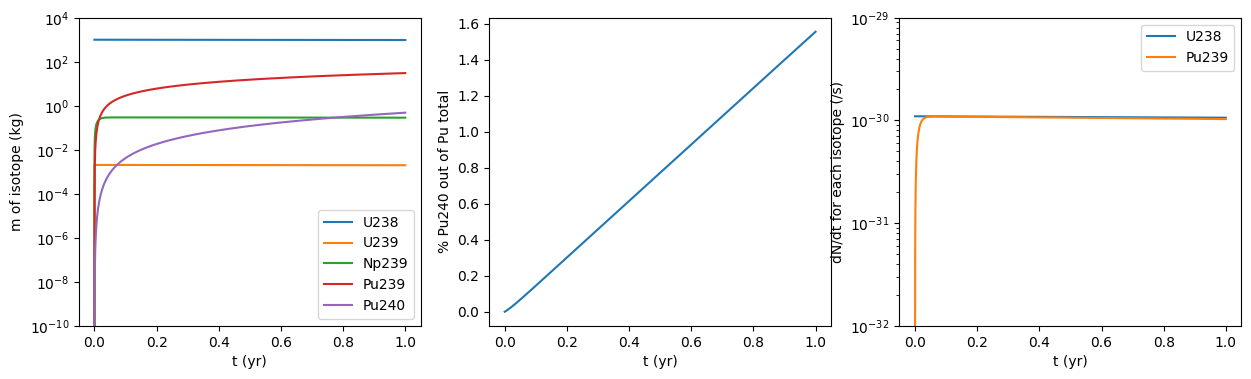

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

ax1.plot(sol.t/YEAR, sol.y[0]*M_U238/KILOGRAM, label='U238')
ax1.plot(sol.t/YEAR, sol.y[1]*M_U239/KILOGRAM, label='U239')
ax1.plot(sol.t/YEAR, sol.y[2]*M_Np239/KILOGRAM, label='Np239')
ax1.plot(sol.t/YEAR, sol.y[3]*M_Pu239/KILOGRAM, label='Pu239')
ax1.plot(sol.t/YEAR, sol.y[4]*M_Pu240/KILOGRAM, label='Pu240')

ax1.set_xlabel('t (yr)')
ax1.set_ylabel('m of isotope (kg)')

ax1.set_yscale('log')
ax1.set_ylim(1e-10,1e4)

ax1.legend()

ax2.plot(sol.t/YEAR, 100*sol.y[4]/(sol.y[3] + sol.y[4]))

ax2.set_xlabel('t (yr)')
ax2.set_ylabel('% Pu240 out of Pu total')

ax3.plot(sol.t/YEAR, lambda_U238*sol.y[0]/SECOND, label='U238')
# ax3.plot(sol.t/YEAR, (lambda_U238*sol.y[0] - lambda_U239*sol.y[1])/SECOND, label='U239')
# ax3.plot(sol.t/YEAR, (lambda_U239*sol.y[1] - lambda_Np239*sol.y[2])/SECOND, label='Np239')
ax3.plot(sol.t/YEAR, (lambda_Np239*sol.y[2] - lambda_Pu239*sol.y[3])/SECOND, label='Pu239')

ax3.set_xlabel('t (yr)')
ax3.set_ylabel('dN/dt for each isotope (/s)')

ax3.set_yscale('log')
ax3.set_ylim(1e-32, 1e-29)

ax3.legend()

/tmp/ipykernel_5879/2330039848.py:3: RuntimeWarning: divide by zero encountered in divide
  ax.plot(sol.t/YEAR, sol.y[0]/sol.y[1], label='U238/U239')
/tmp/ipykernel_5879/2330039848.py:4: RuntimeWarning: invalid value encountered in divide
  ax.plot(sol.t/YEAR, sol.y[2]/sol.y[1], label='Np239/U239')


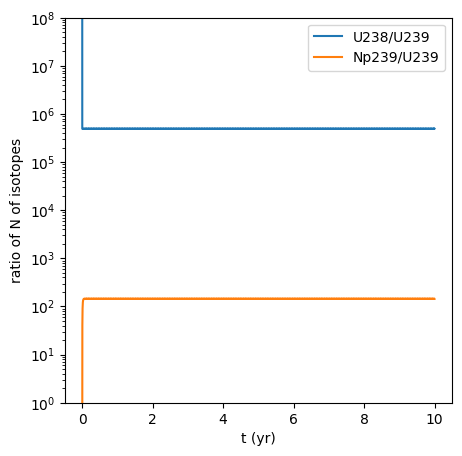

In [64]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(sol.t/YEAR, sol.y[0]/sol.y[1], label='U238/U239')
ax.plot(sol.t/YEAR, sol.y[2]/sol.y[1], label='Np239/U239')

ax.set_xlabel('t (yr)')
ax.set_ylabel('ratio of N of isotopes')

ax.set_yscale('log')
ax.set_ylim(1e0,1e8)

ax.legend()

The mass of the initial blanket of U238 (or inserted rods, etc) is directly proportional to production rate of plutonium by:

$$ \frac{d m_{Pu239}}{dt} = \lambda_{U238} m_{blanket} \frac{M_{Pu239}}{M_{U238}} $$

In [101]:
m_blanket = 100*KILOGRAM

(lambda_U238*m_blanket*M_Pu239/M_U238) * YEAR / KILOGRAM

3.169016710775047

# Putting breeding neutrinos in the code

In [2]:
from lib.lib_rates import *

In [3]:
breeding_spectra